In [1]:
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def encode_labels(train, test, column):
    all_labels, _ = pd.concat([train[column], test[column]], axis=0).factorize(sort=True)
    
    train[column] = all_labels[:len(train)].astype(int)
    test[column] = all_labels[len(train):].astype(int)

def frequency_encode(train, test, columns):
    # Apparently this gives good results in lots of kaggle competitions
    # I couldn't find much online why the frequency is actually useful
    # as a feature. My intuition is that the model might match low or
    # high frequencies with card fraud in a case or another. Eg. if 
    # most of the frauds are coming from a certain email domain, the
    # frequency is going to be a useful feature.
    n = len(train) + len(test)
    for column in columns:
        f = (pd.concat(
                [train[column], test[column]], axis=0
            ).value_counts(dropna=True)/n).to_dict()    
        train[f"{column}_FE"] = train[column].map(f).astype(float)
        test[f"{column}_FE"] = test[column].map(f).astype(float)

def concatenate(train, test, col1, col2):
    new_name = f"{col1}_{col2}"
    train[new_name] = train[col1].astype(str)+ "_" + train[col2].astype(str)
    test[new_name] = test[col1].astype(str) + "_" + test[col2].astype(str)
    
    encode_labels(train, test, new_name)
    

def groupby(train, test, indexes, columns, aggregation):
    # We want for example, the mean transaction value for every card1_address1 pair
    for index in indexes:
        for column in columns:
            new_name = f"{column}_{index}_{aggregation}"

            f = pd.concat([train[[index, column]], test[[index, column]]])
            f = f.groupby([index])[column].agg([aggregation]).reset_index().rename(columns={aggregation: new_name})
            f.index = list(f[index])
            f = f[new_name].to_dict()
            train[new_name] = train[index].map(f).astype(float)
            test[new_name] = train[index].map(f).astype(float)
            train[new_name].fillna(-1, inplace=True)
            test[new_name].fillna(-1, inplace=True)

def groupby_unique(train, test, columns, card_id):
    # every card_id identifies a card
    # but generally a card_id does transactions only from a 
    # handful of email addresses, locations and details as 
    # such. So it's worth creating features that contain
    # the number of unique email addresses, addresses, distances, etc
    
    for column in columns:
        f = pd.concat([train[[card_id] + [column]], test[[card_id] + [column]]], axis=0)
        grouped = f.groupby(card_id)[column].agg(["nunique"])["nunique"].to_dict()
        train[f"{column}_{card_id}_count"] = train[card_id].map(grouped).astype("float32")
        test[f"{column}_{card_id}_count"] = test[card_id].map(grouped).astype("float32")

In [3]:
X_train = pd.read_csv("../ieee_fraud_data/train_transaction.csv")
X_test = pd.read_csv("../ieee_fraud_data/test_transaction.csv")

In [4]:
t1 = X_test["TransactionID"]
y_train = X_train["isFraud"].copy()
X_train = X_train.drop(columns=["isFraud"])

In [5]:
### TransactionDT seems to be in seconds, we can transform to days
X_train["TDay"] = (X_train["TransactionDT"]/86400).astype(int)
X_test["TDay"] = (X_test["TransactionDT"]/86400).astype(int)

for i in [1, 2, 3, 4, 5, 10, 11]:
    X_train[f"D{i}"] = X_train["TDay"] - X_train[f"D{i}"]
    X_test[f"D{i}"] = X_test["TDay"] - X_train[f"D{i}"]

In [6]:
X_train[[f"D{i}" for i in range(1, 16)]].isna().sum()/len(X_train)
#D6, D7, D8, D9, D12, D13, D14 having > 50% of values NA, will drop them completely
X_train = X_train.drop(columns=["D6", "D7", "D8", "D9", "D12", "D13", "D14"])
X_test = X_test.drop(columns=["D6", "D7", "D8", "D9", "D12", "D13", "D14"])

In [ ]:
# X_train.fillna(-9999,inplace=True)
# X_test.fillna(-9999, inplace=True)

In [7]:
## Splitting transaction amount into cents and whole value
## This might be a proxy for foreign currency, as generally
## fractional values are not that common in prices, but due
## to currency exchange prices it will become fractional
X_train["cents"] = (X_train["TransactionAmt"] - np.floor(X_train["TransactionAmt"])).astype("float32")
X_test["cents"] = (X_test["TransactionAmt"] - np.floor(X_test["TransactionAmt"])).astype("float32")

In [8]:
frequency_encode(X_train,X_test,["addr1", "card1", "card2", "card3", "P_emaildomain"])
concatenate(X_train, X_test, "card1", "addr1")
concatenate(X_train, X_test, "card1_addr1", "P_emaildomain")
frequency_encode(X_train, X_test, ["card1_addr1", "card1_addr1_P_emaildomain"])
groupby(X_train, X_test, ["card1", "card1_addr1", "card1_addr1_P_emaildomain"], ["TransactionAmt", "D11"], "mean")
groupby(X_train, X_test, ["card1", "card1_addr1", "card1_addr1_P_emaildomain"], ["TransactionAmt", "D11"], "std")

In [9]:
X_train = X_train.drop(columns=["TransactionID", "TransactionDT", "TDay"])
X_test = X_test.drop(columns=["TransactionID", "TransactionDT", "TDay"])


In [10]:
label_encoder = preprocessing.LabelEncoder()
for column in ["ProductCD", "card4", "card6", "R_emaildomain", "P_emaildomain",
               "M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9"]:
    X_train[column] = label_encoder.fit_transform(X_train[column])
    X_test[column] = label_encoder.fit_transform(X_test[column])

In [ ]:
# Dropping some V columns that are not relevant
# Using https://www.kaggle.com/code/cdeotte/eda-for-columns-v-and-id/notebook as reason for it
# analysis would take too long
# Basically, the easiest thing to do is to:
# - fill NAs
# - try to run PCA
# - do dimensionality reduction and use those features
# v =  [1, 3, 4, 6, 8, 11]
# v += [13, 14, 17, 20, 23, 26, 27, 30]
# v += [36, 37, 40, 41, 44, 47, 48]
# v += [54, 56, 59, 62, 65, 67, 68, 70]
# v += [76, 78, 80, 82, 86, 88, 89, 91]
# v += [96, 98, 99, 104]
# v += [107, 108, 111, 115, 117, 120, 121, 123]
# v += [124, 127, 129, 130, 136]
# v += [138, 139, 142, 147, 156, 162]
# v += [165, 160, 166]
# v += [178, 176, 173, 182]
# v += [187, 203, 205, 207, 215]
# v += [169, 171, 175, 180, 185, 188, 198, 210, 209]
# v += [218, 223, 224, 226, 228, 229, 235]
# v += [240, 258, 257, 253, 252, 260, 261]
# v += [264, 266, 267, 274, 277]
# v += [220, 221, 234, 238, 250, 271]
# v += [294, 284, 285, 286, 291, 297]
# v += [303, 305, 307, 309, 310, 320]
# v += [281, 283, 289, 296, 301, 314]
# v += [332, 325, 335, 338]

# v = set(v)
# to_drop = [f"V{i}" for i in range(1, 340) if i not in v]
# X_train = X_train.drop(columns=to_drop)
# X_test = X_test.drop(columns=to_drop)

In [11]:
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [12]:
model = xgb.XGBClassifier( 
    n_estimators=2000,
    max_depth=12, 
    learning_rate=0.02, 
    subsample=0.8,
    colsample_bytree=0.4, 
    missing=-1, 
    eval_metric='auc',        
)

In [13]:
model.fit(X_train.loc[idxT], y_train[idxT], 
        eval_set=[(X_train.loc[idxV],y_train[idxV])],
        verbose=50, early_stopping_rounds=100)

/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/erik/everything/venvs/ml/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.82132
[50]	validation_0-auc:0.87159
[100]	validation_0-auc:0.88706
[150]	validation_0-auc:0.90231
[200]	validation_0-auc:0.91514
[250]	validation_0-auc:0.92373
[300]	validation_0-auc:0.92931
[350]	validation_0-auc:0.93247
[400]	validation_0-auc:0.93408
[450]	validation_0-auc:0.93463
[500]	validation_0-auc:0.93519
[550]	validation_0-auc:0.93517
[600]	validation_0-auc:0.93487
[616]	validation_0-auc:0.93494


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=-1, monotone_constraints='()',
              n_estimators=2000, n_jobs=1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [14]:
prediction = pd.DataFrame({"isFraud": model.predict_proba(X_test)[:,1], "TransactionId": t1})

In [15]:
prediction.to_csv("result_xgb.csv", index=False)

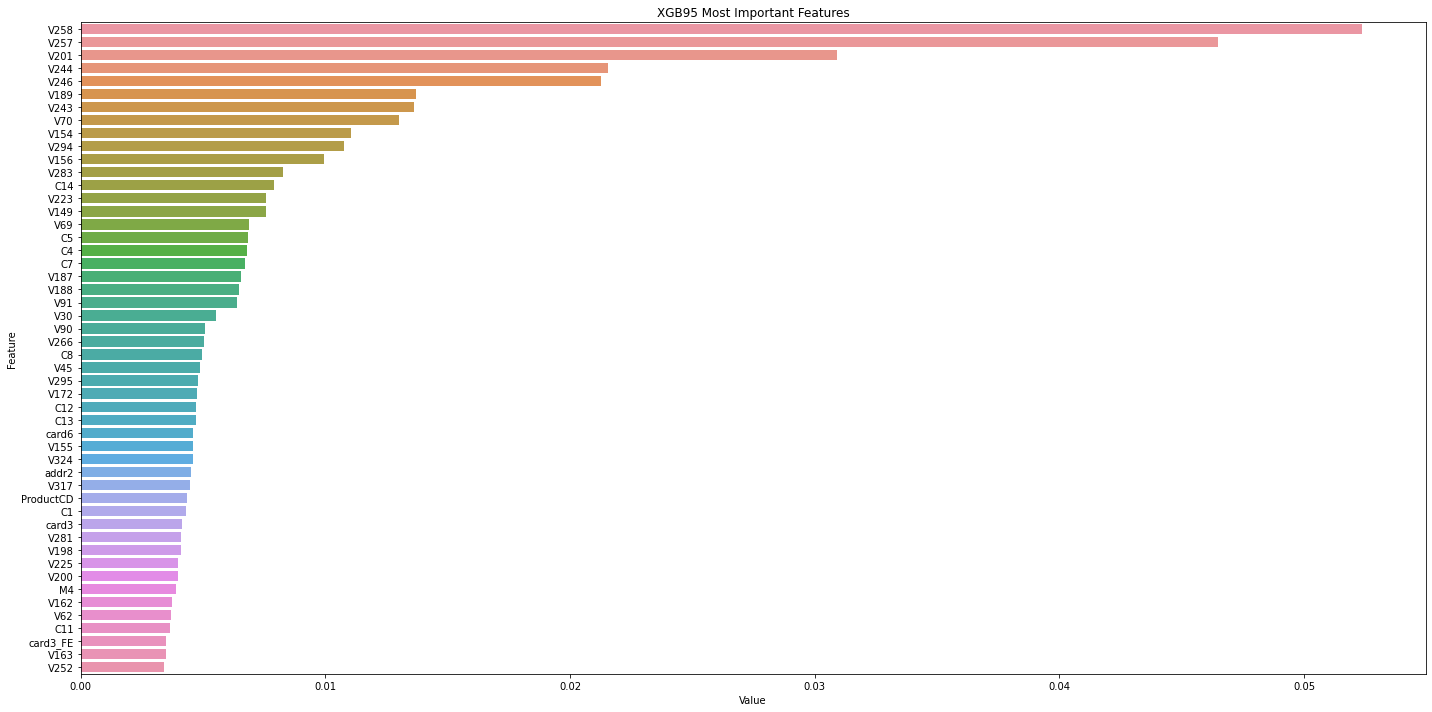

In [16]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGB95 Most Important Features')
plt.tight_layout()
plt.show()
    